# Figure 6: GRB prompt

## Loading the BHNS population

In [10]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import random
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from mycolorpy import colorlist as mcp
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

num = 1000000 #number of binaries
eos = "SFHo" #assumed EoS
table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos),'r') #EM and GW population
mns_max = 2.058838 #NS maximum mass for the assumed SFHo EoS

DCOtype='BHNS'
poptype='A'
path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' #from Broekgaarden+21 

distribution = 'NOT fixed' #or 'fixed' for the same mass distribution at each redshift (approximated redshift evolution)
spin_prescription = 'Zero' #/Qin21/Uniform/Bavera21

### --- Loading Population --- ###

print("Loading intrinsic population")
mbh = table['mbh'][()] #mass of the primary component
mns = table['mns'][()] #mass of the secondary component
lamb_ns = table['lamb_ns'][()] #NS deformability
spin_bh = table['spin_bh'][()] #BH spin
i_tilt = table['i_tilt'][()] #angle between spin and angular momentum 
z = table['z'][()] #redshift
dL = table['dL'][()] #luminosity distance
thv = table['thv'][()] #viewing angle
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()] #dynamical ejecta mass
v_dyn = table['v_dyn'][()] #dynamical ejecta velocity
m_disk = table['m_disk'][()] #disk mass
m_out = table['m_out'][()] #ejected mass
final_x = table['final_x'][()] #final spin
E_bkt = table['E_bkt'][()] #brekout energy
E_k_jet = table['E_k_jet'][()] #jet kinetic energy
Ecore = table['Ec'][()] #jet core energy
Epeak = table['Epeak'][()] #jet peak energy
Eiso = table['Eiso'][()] #jet isotropic equivalent energy

print("Loading GW population")
snr_LVKO4_duty = table['snr_LVKO4_duty'][()] #SNRs LVK O4
snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()] #SNRs LVKI O5

print("Loading EM population (GRB prompt)")
prompt_band = table['prompt_band'][()]
flux_prompt = table['flux_prompt'][()]

table.close()

Loading intrinsic population
Loading GW population
Loading EM population (GRB prompt)


In [11]:
def smoothing(H,sm):
    g = gf(H,sm)
    gr = g.ravel()
    s = np.argsort(gr)
    cr = np.empty(gr.shape)
    cr[s] = np.cumsum(gr[s])
    c = np.reshape(cr/cr.max(),g.shape)
    return c 

In [12]:
### --- Weights --- ###
if poptype == 'A':
    w_type='w_000'
    r0 = 149 
    w_type_high = 'w_000'
    r0_high = 302
    w_type_low = 'w_000'
    r0_low = 62
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_000'
    r0_high = 100
    w_type_low = 'w_000'
    r0_low = 10

spin = calculate_spin_olderCOMPASdata(data_path=path)
if spin_prescription == 'Bavera21':
    spinM1, spinM2  = spin.Bavera21()
if spin_prescription == 'Qin21':
    spinM1, spinM2  = spin.Qin21()
if spin_prescription == 'Uniform':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2  = spin.Bavera21()
    spinM1 = np.random.uniform(0.,0.,spinM1.shape)
    spinM2 = np.random.uniform(0.,0.,spinM2.shape)

bhx=[2.5,27]
nsx=[1.1,3]
spinx=[0.,1.]
binsx=50
binsy=50
binsz=50
       
if distribution == 'fixed':
    C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
  
if distribution == 'NOT fixed':
    C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)

print("")
print("EoS:",eos)
print("Population model:",poptype)
print("The mass and spin distributions are", distribution)
if distribution == 'fixed':
    print("The fiducial SFRD is", w_type, "with r0 =", r0)
    print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
    print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
print("The spin prescription is:", spin_prescription)
print("")

Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero



Computing GW limiting thresholds
Computing GRB PROMPT limiting thresholds
Computing GW limiting thresholds
Computing GRB PROMPT limiting thresholds


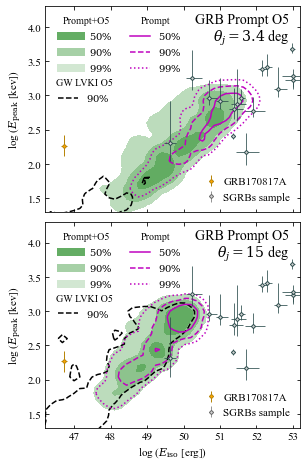

In [13]:
### --- Amati Plane --- ###

recomp_gaussian = False
recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
plt.rcParams["axes.axisbelow"] = False

fig = plt.figure(figsize =([4.3, 6.5]))
gs = fig.add_gridspec(nrows=2, ncols=1,hspace=0.05,right=0.95,top=0.98,bottom=0.08)

bins = 50
smooth = 1.

thetaj = [3.4,15]


for h in range(len(thetaj)):
    
    num_angle=h
    
    ax1 = fig.add_subplot(gs[h, 0])

    Ec = Ecore[:,num_angle]
      
    Eiso_tot, Epeak_tot = Eiso[:,h], Epeak[:,h] 
    flux_prompt_tot = flux_prompt 
    
    #######-------- DETECTION
    
    lim_snr = 12
    lim_prompt = 4.0
    
    
    #GW
    print("Computing GW limiting thresholds")
    
    snr = snr_LVKIO5_duty
    gw_det = snr >= lim_snr
    
    
    #GRB PROMPT
    print("Computing GRB PROMPT limiting thresholds")
    prompt_det_fermi = flux_prompt_tot[:,0,num_angle] >= lim_prompt 
    
    #######-------- GW
    
    H, xedges, yedges= np.histogram2d(np.log10(Eiso_tot[(m_disk>1.e-5)]),np.log10(Epeak_tot[(m_disk>1.e-5)]),weights=(w*gw_det)[(m_disk>1.e-5)],bins=bins,range=[[45.,53.],[0.,4.]])
    
    c = smoothing(H,smooth)
    
    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)
    
    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
    
    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.
    
    X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
    color=mcp.gen_color(cmap="tab10",n=10)
    
    ax1.contour(X,Y,c,levels=[0.1,1.],colors="black",linestyles="--",linewidths=1.5)
    
    #######-------- FERMI
    H, xedges, yedges= np.histogram2d(np.log10(Eiso_tot[(m_disk>1.e-5)]),np.log10(Epeak_tot[(m_disk>1.e-5)]),weights=(w*prompt_det_fermi)[(m_disk>1.e-5)],bins=bins,range=[[45.,53.],[0.,4.]])
    
    c = smoothing(H,smooth)
    
    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)
    
    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
    
    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.
    
    X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax1.contour(X,Y,c,levels=[0.01,0.1,0.5],colors="m",linestyles=[':','--','-'],linewidths=1.5)
    
    #######-------- GW + FERMI
    H, xedges, yedges= np.histogram2d(np.log10(Eiso_tot[(m_disk>1.e-5)]),np.log10(Epeak_tot[(m_disk>1.e-5)]),weights=(w*prompt_det_fermi*gw_det)[(m_disk>1.e-5)],bins=bins,range=[[45.,53.],[0.,4.]])
    
    c = smoothing(H,smooth)
    
    xcentre = np.zeros(bins)
    ycentre = np.zeros(bins)
    
    for j in range(len(xedges)-1):
        xcentre[j] = xedges[j] + (xedges[j+1] - xedges[j]) / 2.
    
    for j in range(len(yedges)-1):
        ycentre[j] = yedges[j] + (yedges[j+1] - yedges[j]) / 2.
    
    X, Y = np.meshgrid(xcentre, ycentre, indexing='ij')
    ax1.contourf(X,Y,c,levels=[0.01,1.],colors="forestgreen",alpha=.3)
    ax1.contourf(X,Y,c,levels=[0.1,1.],colors="forestgreen",alpha=.3)
    ax1.contourf(X,Y,c,levels=[0.5,1.],colors="forestgreen",alpha=.4)
    
    #######-------- SGRB DATA
    
    Lsamples = np.load('./SGRB_data/GBM_BAT_SGRB_spec_or_photoz_L_samples.npy')
    Epsamples = np.load('./SGRB_data/GBM_BAT_SGRB_spec_or_photoz_Ep_samples.npy')
    
    SGRBs = {'Liso':np.median(Lsamples[:-1],axis=1),
             'Liso_err_low':np.median(Lsamples[:-1],axis=1)-np.percentile(Lsamples[:-1],5.,axis=1),
             'Liso_err_high':-np.median(Lsamples[:-1],axis=1)+np.percentile(Lsamples[:-1],95.,axis=1),
             'Ep':np.median(Epsamples[:-1],axis=1),
             'Ep_err_low':np.median(Epsamples[:-1],axis=1)-np.percentile(Epsamples[:-1],5.,axis=1),
             'Ep_err_high':-np.median(Epsamples[:-1],axis=1)+np.percentile(Epsamples[:-1],95.,axis=1)}
    
    flux_fact = [2,2.72,0.89,2.60,1.4925,1.39,1.89,1.45,2.18,1.81,1.84,1.84,1.84,1.84,1.84,1.84]
    time = [0.96,0.96,0.256,0.176,0.24,0.432,0.256,1.152,1.088,1.728,0.896,0.256,1.152,1.44,0.144,0.96]
    
    SGRBs['Liso'] = (SGRBs['Liso']/flux_fact)*time
    SGRBs['Liso_err_low'] = (SGRBs['Liso_err_low']/flux_fact)*time
    SGRBs['Liso_err_high'] = (SGRBs['Liso_err_high']/flux_fact)*time
    
    yerr = (np.log10(1.+(SGRBs['Ep_err_low']/SGRBs['Ep'])),np.log10(1.+(SGRBs['Ep_err_high']/SGRBs['Ep'])))
    xerr = (np.log10(1.+(SGRBs['Liso_err_low']/SGRBs['Liso'])),np.log10(1.+(SGRBs['Liso_err_high']/SGRBs['Liso'])))         
    
    ax1.errorbar(np.log10(SGRBs['Liso']),np.log10(SGRBs['Ep']),xerr=xerr,yerr=yerr,ls='None',marker='D',color='darkslategrey',elinewidth=0.8,markersize=3.,markerfacecolor="lightgrey",alpha=0.99,zorder=3)
    
    Eiso_grb170817a = 5.3e46 #erg
    Eiso_err_grb170817a = 1.e46 #erg
    Epeak_grb170817a = 185 #kev
    Epeak_err_grb170817a = 78 #kev
    ax1.errorbar(np.log10(Eiso_grb170817a),np.log10(Epeak_grb170817a),xerr=np.log10(1.+(Eiso_err_grb170817a/Eiso_grb170817a)),yerr=np.log10(1.+(Epeak_err_grb170817a/Epeak_grb170817a)),marker='D',linestyle='None',color='darkgoldenrod',markerfacecolor="orange",elinewidth=1.,markersize=3.,zorder=3)
    
    if h == 1:
        ax1.set_xlabel(r'log ($E_\mathrm{iso}$ [erg])',size=11)
    ax1.set_ylabel(r'log ($E_\mathrm{peak}$ [kev])',size=11)
    
    if h == 0:
        ax1.tick_params(direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
        ax1.axes.xaxis.set_ticklabels([])
    if h == 1:
        ax1.tick_params(direction='in',left=True,bottom=True,top=True,right=True,labelsize=11)
    
    leg1=plt.legend([Line2D([0],[0],color='m'),Line2D([0],[0],color='m',ls="--"),Line2D([0],[0],color='m',ls=":")],[r'$50\%$',r'$90\%$',r'$99\%$'],bbox_to_anchor=(0.57, 0.999),title="Prompt",title_fontsize=10,prop={'size': 10},frameon=False)
    leg2=plt.legend([Line2D([0],[0],color='forestgreen',lw=8,alpha=0.7),Line2D([0],[0],color="forestgreen",lw=8,alpha=0.4),Line2D([0],[0],color='forestgreen',lw=8,alpha=0.2)],[r'$50\%$',r'$90\%$',r'$99\%$'],bbox_to_anchor=(0.3, 0.999),title="Prompt+O5",title_fontsize=10,prop={'size': 10},frameon=False)
    leg3=plt.legend([Line2D([0],[0],color='black',ls="--")],[r'$90\%$'],bbox_to_anchor=(0.3, 0.7),title="GW LVKI O5",title_fontsize=10,prop={'size': 10},frameon=False)
    plt.gca().add_artist(leg1)
    plt.gca().add_artist(leg2)
    plt.gca().add_artist(leg3)
    
    ax1.errorbar(100,100,yerr=1000,marker='D',linestyle='None',color='darkgoldenrod',markerfacecolor='orange',elinewidth=1.,markersize=3.,label="GRB170817A")
    ax1.errorbar(100,100,yerr=1000,marker='D',linestyle='None',color="dimgrey",elinewidth=0.7,markersize=3.,markerfacecolor="lightgrey",alpha=0.99,label="SGRBs sample")
    ax1.legend(loc=4,prop={'size': 11},frameon=False,handletextpad=0.1)
    
    ax1.text(52.9,4.05,"GRB Prompt O5",size=14,ha='right')
    if h == 0:
        ax1.text(52.9,3.8,r"$\theta_j = 3.4$ deg",size=14,ha='right')
    if h == 1:
        ax1.text(52.9,3.8,r"$\theta_j = 15$ deg",size=14,ha='right')
    ax1.set_xlim(46.2,53.2)
    ax1.set_ylim(1.3,4.3)
    
plt.savefig("prompt.pdf")
plt.show()